In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys,os
sys.path.append('./sailfish/')


datapath = os.path.join( "/dev/shm/",os.environ.get("USER"),"data")
try:
    os.makedirs(datapath,mode=0755)
except OSError as ex:
    print datapath,"::",ex.strerror

if not os.path.isdir('data') and os.path.islink('data'):
    os.remove("data")
    
if not os.path.islink('data'):
    os.symlink(datapath, "data")

/dev/shm/damian.helizanowicz/data :: File exists


# Niestabilność Helmholtza


https://www.youtube.com/watch?v=ELaZ2x42dkU&hd=1

In [71]:
%%writefile data/ex4.py

import numpy as np
from sailfish.subdomain import Subdomain2D
from sailfish.node_type import NTFullBBWall, NTEquilibriumVelocity
from sailfish.controller import LBSimulationController
from sailfish.lb_single import LBFluidSim

class MyBlock(Subdomain2D):
    max_v = 0.1

    def boundary_conditions(self, hx, hy):
        wall_mapv1 = ( (hy == self.gy-1) )
        wall_mapv0 = ( (hy == 0) )
        
        #wall_map_obstacle = ( (hx == self.gx/2) & (hy < 0.45*self.gy) & (hy > 1))
        
        self.set_node(  wall_mapv1 , NTEquilibriumVelocity((self.max_v, 0.0)) )
        self.set_node(wall_mapv0, NTFullBBWall)
        
        #self.set_node(wall_map_obstacle,NTFullBBWall)
    def initial_conditions(self, sim, hx, hy):
        nx,ny = self.gx,self.gy
        sim.rho[:] = 1.0
        sim.vy[(hx==2)&(hy==ny/2-1)] = -0.01
        #border = (hy>2*np.cos(hx/float(nx)*2*np.pi)+ny/2)
        border = (hy>ny/2)       
        #border = (hy>ny/2) | ((hy==ny/2) & (hx>nx/3.) & (hx<2*nx/3.))

        sim.vx[border] = self.max_v
        
        
class MySim(LBFluidSim):
    subdomain = MyBlock

LBSimulationController(MySim).run()

Overwriting data/ex4.py


In [72]:
%%sh
export PYTHONPATH=$PWD/sailfish/
python data/ex4.py --max_iters=10000 --every=100 \
 --lat_nx=1022 --lat_ny=254 \
 --periodic_x --model=mrt \
 --visc=0.001 \
 --output=data/ex4A --output_format=npy



[   722  INFO Master/GPU4] Machine master starting with PID 99629 at 2016-07-05 15:57:56 UTC
[   723  INFO Master/GPU4] Simulation started with: data/ex4.py --max_iters=10000 --every=100 --lat_nx=1022 --lat_ny=254 --periodic_x --model=mrt --visc=0.001 --output=data/ex4A --output_format=npy
[   735  INFO Master/GPU4] Sailfish version: dcc3d33d3c6fe420f78ff1af13471774ef283c74
[   735  INFO Master/GPU4] Handling subdomains: [0]
[   735  INFO Master/GPU4] Subdomain -> GPU map: {0: 0}
[   736  INFO Master/GPU4] Selected backend: cuda
[  5105  INFO Subdomain/0] Initializing subdomain.
[  5107  INFO Subdomain/0] Required memory: 
[  5107  INFO Subdomain/0] . distributions: 18 MiB
[  5107  INFO Subdomain/0] . fields: 3 MiB
[  6517  INFO Subdomain/0] Starting simulation.
[ 10649  INFO Subdomain/0] iteration:2000  speed:109.78 MLUPS
[ 12737  INFO Subdomain/0] iteration:3000  speed:123.66 MLUPS
[ 14789  INFO Subdomain/0] iteration:4000  speed:126.01 MLUPS
[ 16917  INFO Subdomain/0] iteration:5000

In [3]:
!ls -ltra data/ex4*.npz|head

-rw-r--r-- 1 damian.helizanowicz staff 3709 Jul  5 16:35 data/ex4A.0.00000.npz
-rw-r--r-- 1 damian.helizanowicz staff 6141 Jul  5 16:35 data/ex4A.0.00100.npz
-rw-r--r-- 1 damian.helizanowicz staff 6105 Jul  5 16:35 data/ex4A.0.00200.npz
-rw-r--r-- 1 damian.helizanowicz staff 6146 Jul  5 16:35 data/ex4A.0.00300.npz
-rw-r--r-- 1 damian.helizanowicz staff 6143 Jul  5 16:35 data/ex4A.0.00400.npz
-rw-r--r-- 1 damian.helizanowicz staff 6106 Jul  5 16:35 data/ex4A.0.00500.npz
-rw-r--r-- 1 damian.helizanowicz staff 6147 Jul  5 16:35 data/ex4A.0.00600.npz
-rw-r--r-- 1 damian.helizanowicz staff 6134 Jul  5 16:35 data/ex4A.0.00700.npz
-rw-r--r-- 1 damian.helizanowicz staff 6104 Jul  5 16:35 data/ex4A.0.00800.npz
-rw-r--r-- 1 damian.helizanowicz staff 6105 Jul  5 16:35 data/ex4A.0.00900.npz
ls: write error: Broken pipe


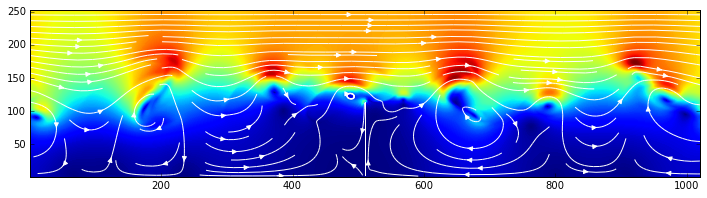

In [65]:
data = np.load("data/ex4A.0.10000.npz")
vx,vy = data['v']
ny,nx = vx.shape
Y,X = np.mgrid[0:ny,0:nx]
plt.figure(figsize=(12,float(ny)/nx*12))
plt.xlim(1,nx-2)
plt.ylim(1,ny-2)
plt.contourf(X,Y,np.sqrt(vy**2+vx**2),256)
plt.streamplot(X,Y,vx,vy,color='white')


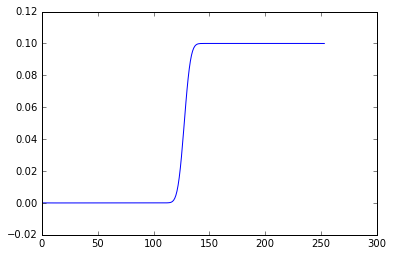

In [16]:
plt.plot(vx[:,800])

### Plotting a part  the domain

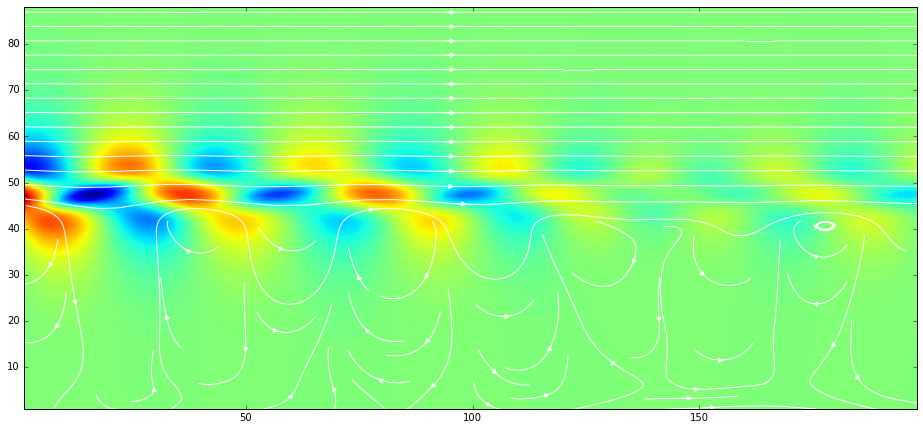

In [66]:
data = np.load("data/ex4A.0.04000.npz")
vx,vy = data['v']
s = (slice(80,170,1),slice(20,220,1))

vx, vy  = vx[s],vy[s]
Dxvx,Dyvx = np.gradient(vx)
Dxvy,Dyvy = np.gradient(vy)
ny,nx = vx.shape
Y,X = np.mgrid[0:ny,0:nx]
plt.figure(figsize=(16,float(ny)/nx*16))
plt.xlim(1,nx-2)
plt.ylim(1,ny-2)
plt.contourf(X,Y,Dyvx-Dxvy,256)
plt.streamplot(X,Y,vx,vy,color='white')


### interactive plotting

In [77]:
import glob
glob.glob("data/ex4A*.npz")

['data/ex4A.0.10000.npz',
 'data/ex4A.0.09900.npz',
 'data/ex4A.0.09800.npz',
 'data/ex4A.0.09700.npz',
 'data/ex4A.0.09600.npz',
 'data/ex4A.0.09500.npz',
 'data/ex4A.0.09400.npz',
 'data/ex4A.0.09300.npz',
 'data/ex4A.0.09200.npz',
 'data/ex4A.0.09100.npz',
 'data/ex4A.0.09000.npz',
 'data/ex4A.0.08900.npz',
 'data/ex4A.0.08800.npz',
 'data/ex4A.0.08700.npz',
 'data/ex4A.0.08600.npz',
 'data/ex4A.0.08500.npz',
 'data/ex4A.0.08400.npz',
 'data/ex4A.0.08300.npz',
 'data/ex4A.0.08200.npz',
 'data/ex4A.0.08100.npz',
 'data/ex4A.0.08000.npz',
 'data/ex4A.0.07900.npz',
 'data/ex4A.0.07800.npz',
 'data/ex4A.0.07700.npz',
 'data/ex4A.0.07600.npz',
 'data/ex4A.0.07500.npz',
 'data/ex4A.0.07400.npz',
 'data/ex4A.0.07300.npz',
 'data/ex4A.0.07200.npz',
 'data/ex4A.0.07100.npz',
 'data/ex4A.0.07000.npz',
 'data/ex4A.0.06900.npz',
 'data/ex4A.0.06800.npz',
 'data/ex4A.0.06700.npz',
 'data/ex4A.0.06600.npz',
 'data/ex4A.0.06500.npz',
 'data/ex4A.0.06400.npz',
 'data/ex4A.0.06300.npz',
 'data/ex4A.

In [73]:
import glob
frames = []
#s = (slice(80,170,1),slice(20,220,1))

data = np.load("data/ex4A.0.10000.npz")
vx,vy = data['v']
ny,nx = vx.shape
Y,X = np.mgrid[0:ny,0:nx]


for fn in sorted(glob.glob("data/ex4A*.npz")):
    vx,vy = np.load(fn)['v']
    #vx, vy  = vx[s],vy[s]
    Dxvx,Dyvx = np.gradient(vx)
    Dxvy,Dyvy = np.gradient(vy)
    frames.append([vx, vy,Dyvx-Dxvy,Dxvx])


In [74]:
print len(frames)


101


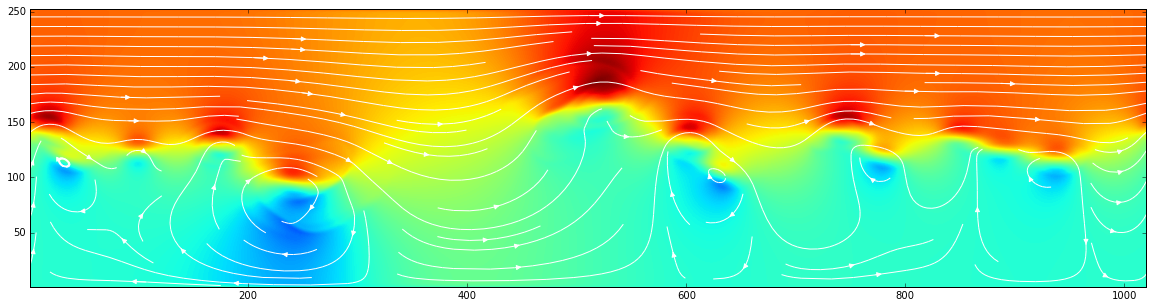

In [90]:
from ipywidgets import interact, interactive, fixed
from ipywidgets import widgets
from IPython.display import display,clear_output
ny,nx = frames[0][0].shape
Y,X = np.mgrid[0:ny,0:nx]

@interact(ith=widgets.IntSlider(min=0,max=len(frames)-1),figsize=widgets.IntSlider(min=0,max=20,value=6))
def g(ith,figsize):
  
    plt.figure(figsize=(figsize,float(ny)/nx*figsize))

    vx,vy=frames[ith][:2]
    plt.xlim(1,nx-2)
    plt.ylim(1,ny-2)
    plt.contourf(X,Y,frames[ith][0],levels=np.linspace(-0.1,0.15,512))
    #plt.imshow(frames[ith][0],vmax=0.01,vmin=-0.001,origin='top')
    plt.streamplot(X,Y,vx,vy,color='white')
    
    plt.show()

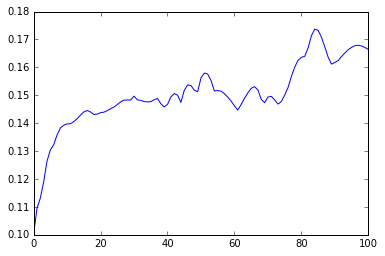

In [59]:
plt.plot( [np.nanmax(f[0]) for f in frames] )

## Geometry experimentation

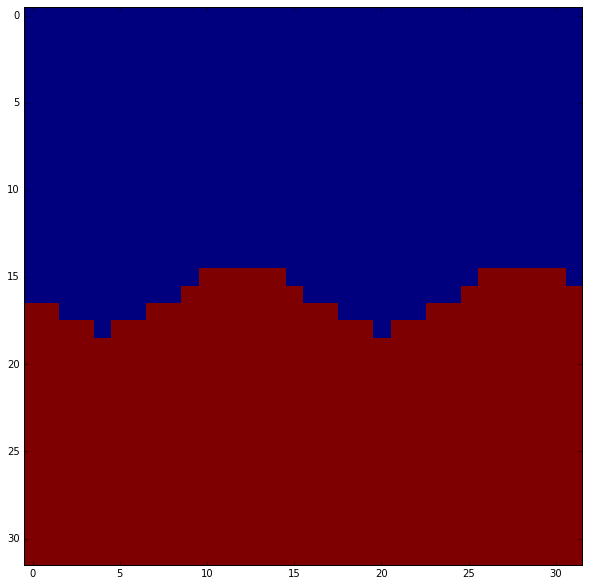

In [18]:
x0,y0,a = 15,8,4
nx,ny=32,32
hy,hx = np.mgrid[0:ny,0:nx]
plt.figure(figsize=(10,float(ny)/nx*10))
plt.imshow( (hy>2*np.sin(2*hx/float(nx)*2*np.pi)+ny/2),interpolation='nearest') 
#plt.imshow( (hy>ny/2) | ((hy==ny/2) & (hx>nx/3.) & (hx<2*nx/3.) ),interpolation='nearest') 
#plt.imshow( hy>5*np.sign(np.sin(2*hx/float(nx)*2*np.pi))+ny/2,interpolation='nearest') 

In [19]:
np.sign(-.2)

-1.0